In [1]:
import numpy as np
import matplotlib.pyplot as plt
import galsim
import ngmix
import time
from typing import Any, Sequence, Optional, Tuple, Iterator, Dict, Callable, Union


# Studying the [Metadetection Paper](https://iopscience.iop.org/article/10.3847/1538-4357/abb595/pdf)

**TODO:**
- Implement Figure 1 of the paper (Toy example of shear-dependent object detection in the presence of PSF):
    1. Two objects are present, convolved by a PSF with no shear. Contours represent constant brightness.
    2. Objects are sheared by $\gamma = (0.0, 0.1)$ **after** the PSF convolution.
    3. Shear $\gamma = (0.0, 0.1)$ applied **before** the PSF convolution, which is more realistic. 

- Implement Figure 5 of the paper (Same as Figure 1, but shear applied to the objects without shearing the space between them $\leftarrow$ *How* do you do this in `galsim`?)
    1. Two objects are present, convolved by a PSF with no shear. Contours represent constant brightness.
    2. Objects are sheared by $\gamma = (0.0, 0.1)$ **after** the PSF convolution.
    3. Shear $\gamma = (0.0, 0.1)$ applied **before** the PSF convolution, which is more realistic.

Found the authors [code](https://github.com/esheldon/metadetect-paper/blob/master/code/toy.py) for reproducing Figures 1 & 5. It was in the papers latex repo and not the main code repo for some reason...

# Code necessary to create Figures 1/5

In [2]:
# arcsec/pixel
SCALE = 0.01
SHEAR = (0.1, 0.0)
LEVELS = 2
ZPERC = [1, 100.0]
FWHM = 0.47
CCOLOR = 'grey65'
SHIFT = 0.4

In [3]:
def create_gal_pair(fwhm: float = 0.47, shift: float = 0.4, fig_num: int = 1):
    """
    Used to create the two gaussian galaxy pairs. The galaxies have the same
    y-coords in the image (when viewed from the center of the image), but 
    different x-coords.

    Args:
    -----
        fwhm: float
            The full width half max of the profile. Given in arcsec.

        shift: float
            The horizontal shift to apply to the galaxies. The shift coords
            are sky coords. A shift of dx move the object horizontally in the
            sky (e.g. west in the local tangent plane of the observation), and
            dy moves the object vertically (north in the local tangent plane).
            Units are typically arcsec.

            Note: If you want to shift the object by a set number (or fraction)
                  pixels in the drawn image, you want to use the `offset` param
                  of `GSObject.drawImage()` rather than using this method.

        fig_num: int
            The figure number we are trying to reproduce ie. Figure 1 (who image is 
            sheared) or Figure 5 (where the shear is applied to the objects without 
            shearing space between them).

    Returns:
    --------
        gal1, gal2: galsim.gaussian.Gaussian
            Returns the two Gaussian galaxy profiles that are next to each other on 
            the sky

    """
    # Create Gaussian galaxy profile of galaxy 1 & shift it to the left
    gal1 = galsim.Gaussian(fwhm=fwhm)
    gal2 = galsim.Gaussian(fwhm=fwhm)

    # If creating figure 1 automatically shift the galaxies for plotting
    if fig_num == 1:
        gal1 = gal1.shift(dx=-shift, dy=0.0)
        gal2 = gal2.shift(dx=shift, dy=0.0)
    else:
        pass

    return gal1, gal2

def get_psf(fwhm: float = 0.47):
    """
    Get the PSF that will be used for both galaxies.

    Args:
    -----
        fwhm: float
            Full width half max for the Gaussian psf

    Returns:
    --------
        galsim.Gaussian(fwhm=fwhm)
            Returns the basic PSF used for all the galaxy pairs
            in the image
    """
    return galsim.Gaussian(fwhm=fwhm)

def create_image(gals: Any, scale: float =  0.01):
    """
    Draw the specific galaxy pair image. This function will be used to create
    one of the three panes in Figure 1/5 in the Metadetect papere
    """
    # Create a 200x200 pixel image with a set pixel scale in units of arcsex/pixel.
    # The .array method at the end returns the actual numpy array of pixel values of
    # the image (ie. dropping the other info that the `GSObject` passes around with it)
    img = gals.drawImage(nx=200,
                        ny=200,
                        scale=scale).array

    # Normalize the image 
    img *= 1.0/img.max()
    return img

def create_paper_fig(scale: float = 0.01, 
                     g1: float = 0.1,
                     g2: float = 0, 
                     fwhm: float = 0.47,
                     shift: float = 0.4,
                     fig_num: int = 1):
    """
    Creates Figure 1 or Figure 5 of the Metadetect Paper 
    (https://iopscience.iop.org/article/10.3847/1538-4357/abb595/pdf).

    Function creates the three different panels in each Figure ie.
        (a.): Two galaxies convolved with the PSF with no shear
        (b.): Two galaxies convolved with shear applied AFTER PSF convolution.
        (c.): Two galaxies with shear applied BEFORE PSF convolution.

    The difference between Figure 1 and 5 is that:
        (1.) Shear is applied to the whole image.
        (5.) Shear is applied to the objects without shearing the space between them.
             (ie. the galaxies are sheared completely independently, while still being
              in the same LOS).

    Args:
    -----
        scale: float
            WIP
        g1: float
            Reduced shear component 1. This shears in a "plus sign".
        g2: float
            Reduced shear component 2. This shears in an "X".
        fwhm: float
            The full width half max of the profile. Given in arcsec.
        shift: float
            The horizontal shift to apply to the galaxies. The shift coords
            are sky coords. A shift of dx move the object horizontally in the
            sky (e.g. west in the local tangent plane of the observation), and
            dy moves the object vertically (north in the local tangent plane).
            Units are typically arcsec.

            Note: If you want to shift the object by a set number (or fraction)
                  pixels in the drawn image, you want to use the `offset` param
                  of `GSObject.drawImage()` rather than using this method.
        fig_num: int
            The figure number we are trying to reproduce ie. Figure 1 (who image is 
            sheared) or Figure 5 (where the shear is applied to the objects without 
            shearing space between them).

    Returns:
    --------
        im_no_shear: np.ndarray
            The normalized galaxy pair image with no shear applied.
        im_after_sheared: np.ndarray
            The normalized galaxy pair image that is convolved before shearing.
        im_before_sheared: np.ndarray
            The normalized galaxy pair image that is sheared before convolution.
    """
    gal1, gal2 = create_gal_pair(fwhm, shift, fig_num)
    psf = get_psf(fwhm)

    # Create galaxy pairs to recreate Figure 1 in Metadetect Paper
    if int(fig_num) == 1:

        # Create a pair of galaxies
        gal_pair = galsim.Add(gal1, gal2)
        
        # Create Figure 1a
        no_shear = galsim.Convolve(gal_pair, psf) # convolve PSF with galaxies

        # Create Figure 1b sheared AFTER psf convolution
        after = galsim.Convolve(gal_pair, psf) # convolve gals w/ psf
        after_sheared = after.shear(g1=g1, g2=g2) # shear AFTER 

        # Create Figure 1c (sheared before psf convolution)
        before = galsim.Add(gal1, gal2).shear(g1=g1, g2=g2) # shear BEFORE
        before_sheared = galsim.Convolve(before, psf) # convolve sheared gals w/ psf

    else:

        gal_pair = galsim.Add(gal1.shift(dx=-shift, dy=0.0), 
                              gal2.shift(dx=+shift, dy=0.0))

        # Create Figure 5a
        no_shear = galsim.Convolve(gal_pair, psf)

        # Create Figure 5b sheared AFTER psf convolution for EACH
        # galaxy separately, ie. not shearing entire image
        gal1_after = galsim.Convolve(gal1, psf).shear(g1=g1, g2=g2)
        gal2_after = galsim.Convolve(gal2, psf).shear(g1=g1, g2=g2)

        # We shift here after shearing, so that the galaxies are the only
        # thing that is sheared (ie. NOT shearing the entire image)
        after_sheared = galsim.Add(gal1_after.shift(dx=-shift, dy=0.0), 
                                   gal2_after.shift(dx=+shift, dy=0.0))

        # Create Figure 5c sheared BEFORE psf convolution for EACH
        # galaxy separately.
        gal1_before = gal1.shear(g1=g1, g2=g2)
        gal1_before = galsim.Convolve(gal1_before, psf)

        gal2_before = gal2.shear(g1=g1, g2=g2)
        gal2_before = galsim.Convolve(gal2_before, psf)

        # We shift here after shearing, so that the galaxies are the only
        # thing that is sheared (ie. NOT shearing the entire image)
        before_sheared = galsim.Add(gal1_before.shift(dx=-shift, dy=0.0), 
                                    gal2_before.shift(dx=+shift, dy=0.0))

    # Get the normalized images of the three different scenarios
    im_no_shear = create_image(no_shear)
    im_after_sheared = create_image(after_sheared)
    im_before_sheared =  create_image(before_sheared)

    return im_no_shear, im_after_sheared, im_before_sheared

def visualize_fig15(scale: float = 0.01, 
                    g1: float = 0.1,
                    g2: float = 0, 
                    levels: float = 2.0,
                    fwhm: float = 0.47,
                    shift: float = 0.4,
                    fig_num: int = 1):
    """
    Args:
    -----
        scale: float
            WIP
        g1: float
            Reduced shear component 1. This shears in a "plus sign".
        g2: float
            Reduced shear component 2. This shears in an "X".
        levels: float
            The constant surface brightness value that the contour follows.
            I.e. if levels = 0.7 we create contours at levels where the normalized 
            SB is 0.7

        fwhm: float
            The full width half max of the profile. Given in arcsec.
        shift: float
            The horizontal shift to apply to the galaxies. The shift coords
            are sky coords. A shift of dx move the object horizontally in the
            sky (e.g. west in the local tangent plane of the observation), and
            dy moves the object vertically (north in the local tangent plane).
            Units are typically arcsec.

            Note: If you want to shift the object by a set number (or fraction)
                  pixels in the drawn image, you want to use the `offset` param
                  of `GSObject.drawImage()` rather than using this method.
        fig_num: int
            The figure number we are trying to reproduce ie. Figure 1 (who image is 
            sheared) or Figure 5 (where the shear is applied to the objects without 
            shearing space between them).
    """   
    no_shear, sheared_after, sheared_before = create_paper_fig(scale=scale,
                                                               g1=g1,
                                                               g2=g2,
                                                               fwhm=fwhm,
                                                               shift=shift,
                                                               fig_num=fig_num)
    print(type(no_shear))
    # Define the size of the colorbar
    colorbar_width = 0.01

    # Plot the image with a fixed grid layout
    fig, axs = plt.subplots(1, 3, figsize=(16, 6),
                            gridspec_kw={'width_ratios': [1, 1, 1]})

    # Plot the images
    im0 = axs[0].imshow(no_shear, cmap='gray_r', origin='upper')
    axs[0].contour(no_shear, levels=[levels], colors='r')
    axs[0].invert_yaxis()
    axs[0].set(title='No Shear')

    im1 = axs[1].imshow(sheared_after, cmap='gray_r', origin='upper')
    axs[1].contour(sheared_after, levels=[levels], colors='r')
    axs[1].invert_yaxis()
    axs[1].set_title('Sheared AFTER PSF convolution')

    im2 = axs[2].imshow(sheared_before, cmap='gray_r', origin='upper')
    axs[2].contour(sheared_before, levels=[levels], colors='r')
    axs[2].invert_yaxis()
    axs[2].set_title('Sheared BEFORE PSF convolution')

    # Add colorbar to the last plot
    cbar_ax = fig.add_axes([axs[2].get_position().x1 + 0.1, axs[2].get_position().y0,
                            colorbar_width, axs[2].get_position().height])
    cbar = fig.colorbar(im2, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=10)

    # Adjust the spacing between the plots
    fig.tight_layout()

    plt.show()

# Figure 1

<class 'numpy.ndarray'>


/var/folders/kh/07h47s9d6sj9l1d2plg9tzn40000gn/T/ipykernel_15966/264897702.py:269: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


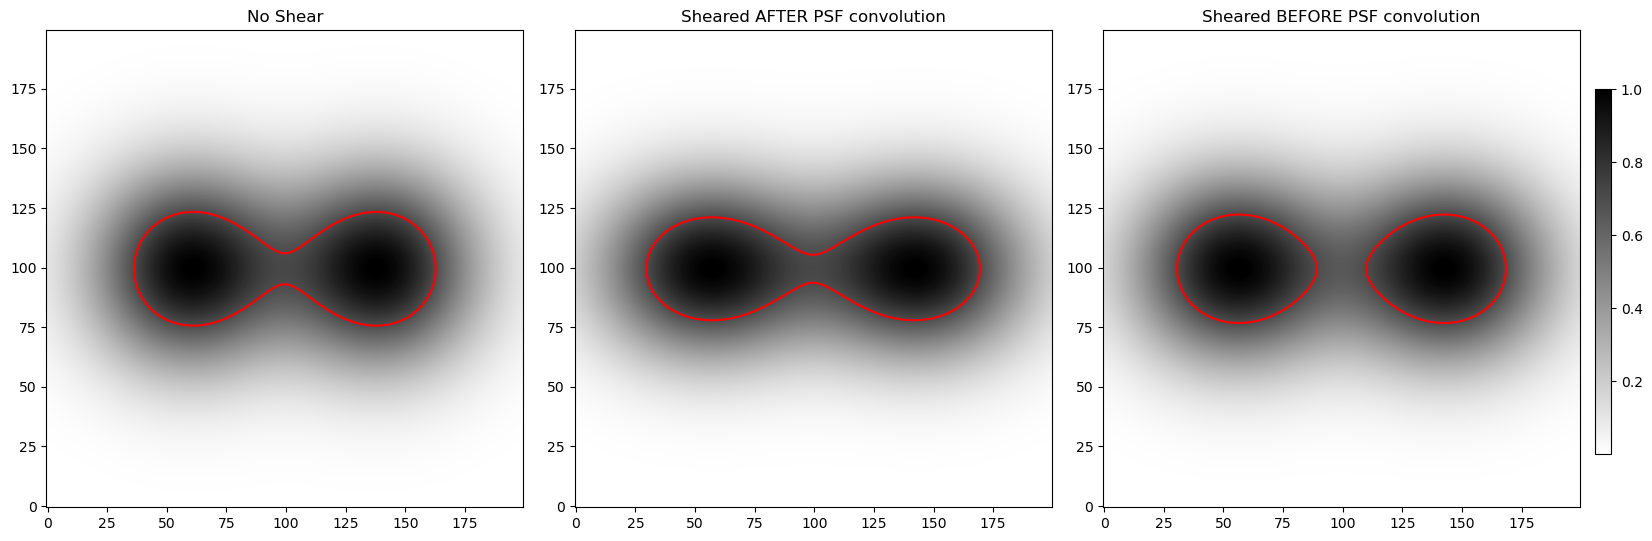

In [4]:
 visualize_fig15(scale=0.01, 
                    g1=0.1,
                    g2=0, 
                    levels=0.7,
                    fwhm=0.47,
                    shift=0.4,
                    fig_num=1)

# Figure 5

<class 'numpy.ndarray'>


/var/folders/kh/07h47s9d6sj9l1d2plg9tzn40000gn/T/ipykernel_15966/264897702.py:269: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


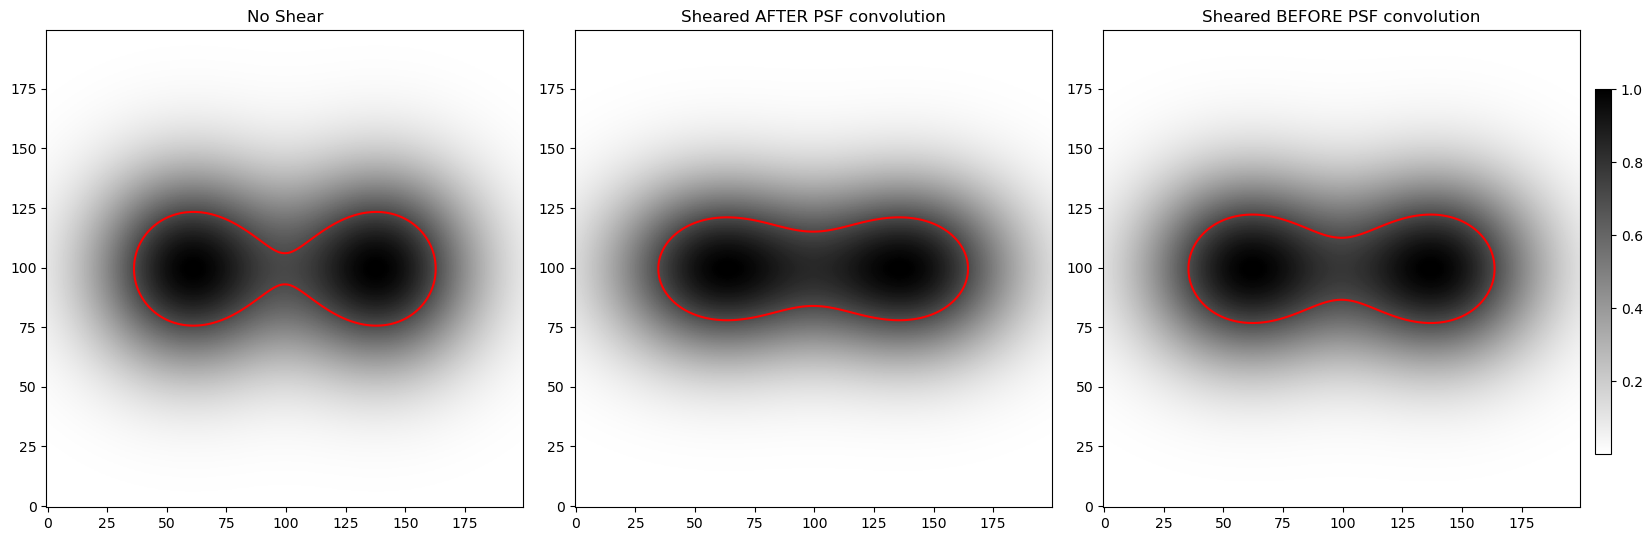

In [5]:
 visualize_fig15(scale=0.01, 
                    g1=0.1,
                    g2=0, 
                    levels=0.7,
                    fwhm=0.47,
                    shift=0.4,
                    fig_num=5)